# PANDA EfficientNet-B0 Baseline with 36 x tiles_256

Hi everyone,

I'm here to show you how to train a single efficientnet-b0 model to get LB 0.87

Inference kernel is https://www.kaggle.com/haqishen/panda-inference-w-36-tiles-256

If you find find any of the following idea helps, please upvote me, THANKS!

# Summary of This Baseline

* Using tiling method based on https://www.kaggle.com/iafoss/panda-16x128x128-tiles
    * Simply setting the `N = 36` and `sz=256` then extract from median resolution
* Create 6x6 big image from 36 tiles
* Efficientnet-B0
* Binning label
    * E.g.
        * `label = [0,0,0,0,0]` means `isup_grade = 0`
        * `label = [1,1,1,0,0]` means `isup_grade = 3`
        * `label = [1,1,1,1,1]` means `isup_grade = 5`
* BCE loss
* Augmentation on both tile level and big image level
* CosineAnnealingLR for one round

# MEMO

The full training process need over `10h` to run so you should run it on your own machine.

# Update
* Version 1
    * Baseline
* Version 2, 3
    * Add some Markdown Text
* Version 4
    * Fix `init_lr` from 3e-5 to 3e-4
* Version 5
    * Add warmup scheduler
    * Add training log for this version
* Version 6
    * Fix the bug that train from scratch. Now it's train from ImageNet pretrained weights. Actually I haven't tried train from scratch yet.
* Version 7, 8
    * Update accuracy calculate.
    * Fix tiny bug.

In [87]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [1]:
DEBUG = True

In [2]:
!pip install git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

  Cloning https://github.com/ildoonet/pytorch-gradual-warmup-lr.git to /private/var/folders/rb/zm5xn6qd1yb4_rpwm4ppqg200000gn/T/pip-req-build-g77vj8uc
  Stored in directory: /private/var/folders/rb/zm5xn6qd1yb4_rpwm4ppqg200000gn/T/pip-ephem-wheel-cache-eaeed21i/wheels/b7/24/83/d30234cc013cff538805b14df916e79091f7cf9ee2c5bf3a64
Successfully built warmup-scheduler


In [3]:
import os
import sys
#sys.path = ['../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master',] + sys.path

In [10]:
import time
import skimage.io
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from warmup_scheduler import GradualWarmupScheduler
from efficientnet_pytorch import model as enet, EfficientNet
import albumentations
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score
from tqdm import tqdm_notebook as tqdm



# Config

In [ ]:
TRAIN = '../data/tiles_data/train'
LABELS = '../data/train.csv'

In [64]:
image_ids = {filepath[:32] for filepath in os.listdir(tiles_folder)}

In [105]:
#data_dir = '../input/prostate-cancer-grade-assessment'
df_train = pd.read_csv('../data/train.csv').set_index('image_id')
#image_folder = os.path.join(data_dir, 'train_images')
tiles_folder = '../data/tiles_data/train'
kernel_type = 'how_to_train_effnet_b0_to_get_LB_0.86'

enet_type = 'efficientnet-b0'
fold = 0
tile_size = 128
image_size = 128
n_tiles = 16
batch_size = 4
num_workers = 4
out_dim = 5
init_lr = 3e-4
warmup_factor = 10

warmup_epo = 1
n_epochs = 2 if DEBUG else 30
df_train = df_train.loc[image_ids].reset_index()
df_train = df_train.sample(100).reset_index(drop=True) if DEBUG else df_train

In [106]:
df_train.head()

,image_id,data_provider,isup_grade,gleason_score
0,fe060ad89a138fa24eed135c4b46954c,karolinska,5,4+5
1,2f3d3eff62b40b0e7a14f0ccbdfde2f8,karolinska,1,3+3
2,830a3227ef20baac63414e821f96f740,radboud,5,5+4
3,97bf4d65f07954809658e01478408637,radboud,4,4+4
4,a0ac3589042f9e99d31b521b5b56ac06,karolinska,5,4+5


# Create Folds

In [107]:
skf = StratifiedKFold(5, shuffle=True, random_state=42)
df_train['fold'] = -1
for i, (train_idx, valid_idx) in enumerate(skf.split(df_train, df_train['isup_grade'])):
    df_train.loc[valid_idx, 'fold'] = i
df_train.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,fe060ad89a138fa24eed135c4b46954c,karolinska,5,4+5,4
1,2f3d3eff62b40b0e7a14f0ccbdfde2f8,karolinska,1,3+3,4
2,830a3227ef20baac63414e821f96f740,radboud,5,5+4,3
3,97bf4d65f07954809658e01478408637,radboud,4,4+4,3
4,a0ac3589042f9e99d31b521b5b56ac06,karolinska,5,4+5,0


# Model

In [9]:
#pretrained_model = {'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'}

In [13]:
class enetv2(nn.Module):
    def __init__(self, out_dim):
        super(enetv2, self).__init__()
        #self.enet = enet.EfficientNet.from_name(backbone)
        #self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.enet = EfficientNet.from_pretrained('efficientnet-b0') 
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [14]:
model = enetv2(out_dim)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /Users/jacobgoffin/.cache/torch/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:40<00:00, 526kB/s] 

Loaded pretrained weights for efficientnet-b0


In [ ]:
class TileTrainDataSet(Dataset):
    def __init__(self, df, transform_fn=None):
        self.X = df['image_id']
        self.Y = df['isup_grade']
        self.transform = transform_fn

    def __getitem__(self, idx):
        # Take image id and use the first N tiles (all have the same target label)
        img_id = self.X[idx]
        imgs = []
        for i in range(N):
            img = io.imread(os.path.join(tiles_folder,img_id+f"_{i}.png"))
            
            if self.transform:
                augmented = self.transform(image=img)
                img = augmented['image']
            imgs.append(img)
        # Final shape is x:  N x 3 x 128 x 128, y: 1
        x = torch.stack(imgs)
        return x, self.Y[idx]

    def __len__(self):
        return len(self.Y)

# Dataset

In [115]:
def get_tiles(img, mode=0):
        result = []
        h, w, c = img.shape
        pad_h = (tile_size - h % tile_size) % tile_size + ((tile_size * mode) // 2)
        pad_w = (tile_size - w % tile_size) % tile_size + ((tile_size * mode) // 2)

        img2 = np.pad(img,[[pad_h // 2, pad_h - pad_h // 2], [pad_w // 2,pad_w - pad_w//2], [0,0]], constant_values=255)
        img3 = img2.reshape(
            img2.shape[0] // tile_size,
            tile_size,
            img2.shape[1] // tile_size,
            tile_size,
            3
        )

        img3 = img3.transpose(0,2,1,3,4).reshape(-1, tile_size, tile_size,3)
        n_tiles_with_info = (img3.reshape(img3.shape[0],-1).sum(1) < tile_size ** 2 * 3 * 255).sum()
        if len(img3) < n_tiles:
            img3 = np.pad(img3,[[0,n_tiles-len(img3)],[0,0],[0,0],[0,0]], constant_values=255)
        idxs = np.argsort(img3.reshape(img3.shape[0],-1).sum(-1))[:n_tiles]
        img3 = img3[idxs]
        for i in range(len(img3)):
            result.append({'img':img3[i], 'idx':i})
        return result, n_tiles_with_info >= n_tiles


class PANDADataset(Dataset):
    def __init__(self,
                 df,
                 image_size,
                 n_tiles=n_tiles,
                 tile_mode=0,
                 rand=False,
                 transform=None,
                ):

        self.df = df.reset_index(drop=True)
        self.image_size = image_size
        self.n_tiles = n_tiles
        self.tile_mode = tile_mode
        self.rand = rand
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        img_id = row.image_id
        
        #tiff_file = os.path.join(image_folder, f'{img_id}.tiff')
        #image = skimage.io.MultiImage(tiff_file)[1]
        #tiles, OK = get_tiles(image, self.tile_mode)
        imgs = []
        for i in range(self.n_tiles):
            img = skimage.io.imread(os.path.join(tiles_folder,img_id+f"_{i}.png"))
            imgs.append(img)
        # Final shape is x:  n_tiles x 128 x 128 x 3
        imgs = np.array(imgs)
        #print(imgs.shape)
        if self.rand:
            idxes = np.random.choice(list(range(self.n_tiles)), self.n_tiles, replace=False)
        else:
            idxes = list(range(self.n_tiles))

        n_row_tiles = int(np.sqrt(self.n_tiles))
        mosaic = np.zeros((image_size * n_row_tiles, image_size * n_row_tiles, 3))
        for h in range(n_row_tiles):
            for w in range(n_row_tiles):
                i = h * n_row_tiles + w
    
                if len(imgs) > idxes[i]:
                    this_img = imgs[idxes[i]]
                else:
                    this_img = np.ones((self.image_size, self.image_size, 3)).astype(np.uint8) * 255
                this_img = 255 - this_img
                if self.transform is not None:
                    this_img = self.transform(image=this_img)['image']
                h1 = h * image_size
                w1 = w * image_size
                mosaic[h1:h1+image_size, w1:w1+image_size] = this_img

        if self.transform is not None:
            mosaic = self.transform(image=mosaic)['image']
        mosaic = mosaic.astype(np.float32)
        mosaic /= 255
        mosaic = mosaic.transpose(2, 0, 1)  # shape: 3 x (n_row_tiles*tile_size) x (n_row_tiles*tile_size)

        label = np.zeros(5).astype(np.float32)
        label[:row.isup_grade] = 1.
        return torch.tensor(mosaic), torch.tensor(label)


In [116]:
train_ds = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)

In [117]:
img, label = train_ds[0]

In [118]:
img.shape

torch.Size([3, 512, 512])

# Augmentations

In [119]:
transforms_train = albumentations.Compose([
    albumentations.Transpose(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    #albumentations.augmentations.transforms.Rotate(limit=20,p=0.5)
])
transforms_val = albumentations.Compose([])

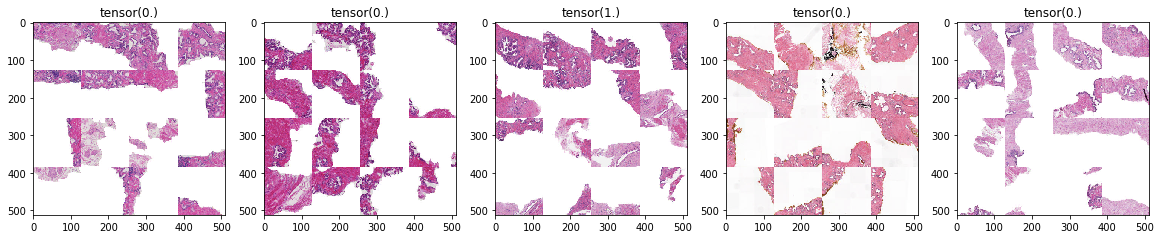

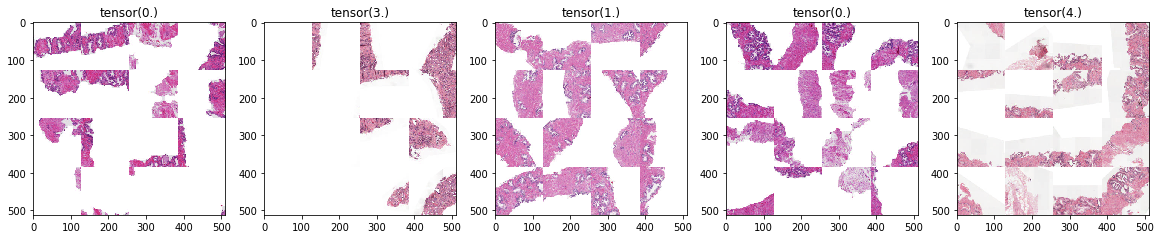

In [120]:
dataset_show = PANDADataset(df_train, image_size, n_tiles, 0, rand=False, transform=transforms_train)
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = np.random.randint(0, len(dataset_show))
        img, label = dataset_show[idx]
        axarr[p].imshow(1-img.transpose(0, 1).transpose(1,2).squeeze())
        axarr[p].set_title(str(sum(label)))


# Loss

In [121]:
criterion = nn.BCEWithLogitsLoss()

# Train & Val

In [122]:
def train_epoch(loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        
        data, target = data.to(device), target.to(device)
        loss_func = criterion
        optimizer.zero_grad()
        logits = model(data)
        loss = loss_func(logits, target)
        loss.backward()
        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(loader, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    PREDS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
            logits = model(data)

            loss = criterion(logits, target)

            pred = logits.sigmoid().sum(1).detach().round()
            LOGITS.append(logits)
            PREDS.append(pred)
            TARGETS.append(target.sum(1))

            val_loss.append(loss.detach().cpu().numpy())
        val_loss = np.mean(val_loss)

    LOGITS = torch.cat(LOGITS).cpu().numpy()
    PREDS = torch.cat(PREDS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    acc = (PREDS == TARGETS).mean() * 100.
    
    qwk = cohen_kappa_score(PREDS, TARGETS, weights='quadratic')
    qwk_k = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'karolinska'], df_valid[df_valid['data_provider'] == 'karolinska'].isup_grade.values, weights='quadratic')
    qwk_r = cohen_kappa_score(PREDS[df_valid['data_provider'] == 'radboud'], df_valid[df_valid['data_provider'] == 'radboud'].isup_grade.values, weights='quadratic')
    print('qwk', qwk, 'qwk_k', qwk_k, 'qwk_r', qwk_r)

    if get_output:
        return LOGITS
    else:
        return val_loss, acc, qwk

    

# Create Dataloader & Model & Optimizer

In [123]:
train_idx = np.where((df_train['fold'] != fold))[0]
valid_idx = np.where((df_train['fold'] == fold))[0]

df_this  = df_train.loc[train_idx]
df_valid = df_train.loc[valid_idx]

dataset_train = PANDADataset(df_this , image_size, n_tiles, transform=transforms_train)
dataset_valid = PANDADataset(df_valid, image_size, n_tiles, transform=transforms_val)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, sampler=RandomSampler(dataset_train), num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, sampler=SequentialSampler(dataset_valid), num_workers=num_workers)

model = enetv2(out_dim=out_dim)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr=init_lr/warmup_factor)
scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs-warmup_epo)
scheduler = GradualWarmupScheduler(optimizer, multiplier=warmup_factor, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

print(len(dataset_train), len(dataset_valid))

Loaded pretrained weights for efficientnet-b0
80 20


In [126]:
time.ctime()

'Sat Jun 20 17:09:58 2020'

# Run Training

In [124]:

qwk_max = 0.
best_file = f'../models/efficientnet_best_fold{fold}.pth'
for epoch in range(1, n_epochs+1):
    print(time.ctime(), 'Epoch:', epoch)
    scheduler.step(epoch-1)

    train_loss = train_epoch(train_loader, optimizer)
    val_loss, acc, qwk = val_epoch(valid_loader)

    content = time.ctime() + ' ' + f'Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, val loss: {np.mean(val_loss):.5f}, acc: {(acc):.5f}, qwk: {(qwk):.5f}'
    print(content)
    with open(f'../logs/log_efficientnet.txt', 'a') as appender:
        appender.write(content + '\n')

    if qwk > qwk_max:
        print('score2 ({:.6f} --> {:.6f}).  Saving model ...'.format(qwk_max, qwk))
        torch.save(model.state_dict(), best_file)
        qwk_max = qwk

torch.save(model.state_dict(), os.path.join(f'{kernel_type}_final_fold{fold}.pth'))

Sat Jun 20 16:45:31 2020 Epoch: 1


qwk 0.11144578313253017 qwk_k 0.0 qwk_r 0.09395973154362403
Sat Jun 20 16:49:38 2020 Epoch 1, lr: 0.0000300, train loss: 0.69961, val loss: 0.71410, acc: 20.00000, qwk: 0.11145
score2 (0.000000 --> 0.111446).  Saving model ...
Sat Jun 20 16:49:38 2020 Epoch: 2


qwk 0.18103448275862066 qwk_k 0.1954022988505747 qwk_r -0.019108280254777066
Sat Jun 20 16:53:10 2020 Epoch 2, lr: 0.0003000, train loss: 0.61270, val loss: 0.58836, acc: 25.00000, qwk: 0.18103
score2 (0.111446 --> 0.181034).  Saving model ...
